In [319]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from tensorflow.keras.datasets import mnist

from skimage import io, transform, color, filters
from matplotlib import pyplot as plt
from skimage.morphology import disk, ball
from skimage.filters import threshold_otsu

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import glob
from tqdm.notebook import tqdm
import imutils

from numba import jit


# Handwritten digit classification

In [138]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28,28,1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 6, 6, 32)          25632     
_________________________________________________________________
batch_normalization_26 (Batc (None, 6, 6, 32)          128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 6, 6, 32)         

In [132]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_test=x_test.reshape(-1,28,28,1)/255
x_train=x_train.reshape(-1,28,28,1)/255
y_test=tf.keras.utils.to_categorical(y_test)
y_train=tf.keras.utils.to_categorical(y_train)


In [139]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [140]:
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=256),
                              epochs = 20, validation_data = (x_test,y_test),
                              verbose = 1)

Epoch 1/20
235/235 [==============================] - 13s 42ms/step - loss: 1.5697 - accuracy: 0.5491 - val_loss: 1.5646 - val_accuracy: 0.3639
Epoch 2/20
235/235 [==============================] - 10s 42ms/step - loss: 0.2927 - accuracy: 0.9178 - val_loss: 0.1556 - val_accuracy: 0.9513
Epoch 3/20
235/235 [==============================] - 10s 42ms/step - loss: 0.1845 - accuracy: 0.9485 - val_loss: 0.0698 - val_accuracy: 0.9787
Epoch 4/20
235/235 [==============================] - 10s 42ms/step - loss: 0.1402 - accuracy: 0.9611 - val_loss: 0.0624 - val_accuracy: 0.9809
Epoch 5/20
116/235 [=============>................] - ETA: 4s - loss: 0.1248 - accuracy: 0.9662

KeyboardInterrupt: 

In [141]:
model.save_weights('mnist.h5')

In [146]:
model.load_weights('mnist.h5')

In [260]:
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = np.ones((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return np.array(framed_img)

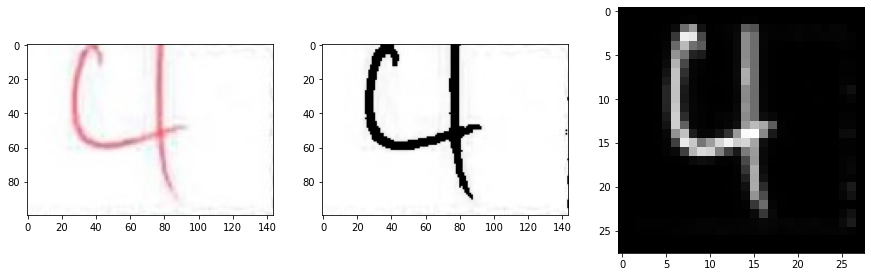

0 1.7521093e-05
1 3.1571282e-05
2 6.3217817e-06
3 3.6528295e-06
4 0.9815214
5 2.822762e-05
6 0.00032988263
7 4.2955537e-05
8 2.6120948e-05
9 0.017992446


4

In [281]:
img=io.imread('4_c.jpg')
# img=io.imread('4.jpg')
# img=io.imread('3.jpg')
# img=io.imread('3_c.png')
# img=io.imread('5.png')
# img=io.imread('5_c.png')
# img=io.imread('error_c.jpg')

gray=color.rgb2gray(img)

gra_f=np.where(gray>0.9, gray, 0)
img_t=frame_image(gra_f,10)
img_t=1-img_t

img_t=transform.resize(img_t, (28,28,1))

res=model.predict(tf.expand_dims(img_t,0))

fig,(ax1,ax2, ax3)=plt.subplots(1,3, figsize=(15,6))

ax1.imshow(img)
ax2.imshow(gra_f,cmap='gray')
ax3.imshow(img_t,cmap='gray')

plt.show()
for i in range(len(res[0])):
    print(i,res[0,i])

np.argmax(res)
